<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">
    Être ou ne pas être ?
</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">
    Un problème de classification binaire sur des données médicales artificelles
<br/>

---

# Présentation du challenge

## La question principale de ce challenge est :

* Comment prédire la survie d'un·e patient·e compte tenu de son dossier médical ?
    
* Plus précisément, vous devrez prédire la survie des patient·e·s pendant leur séjour à l'hôpital

Chaque jour, le personnel soignant collecte de nombreuses informations sur les patient·e·s en posant des questions et en utilisant des outils de mesure (stéthoscope, analyse de sang, capteurs, etc.). Ces données sont très utiles pour surveiller l'état de santé, diagnostiquer et choisir les traitements.

Elles peuvent également être utilisées pour l'analyse statistique prédictive.

## Données

L'ensemble de données contient des informations sur 80'000 patient·e·s, représentés par des variables (descripteurs) catégorielles, binaires et numériques. Ces variables sont, par exemple, l'âge, le sexe, l'origine ethnique, l'état matrimonial, ainsi que des données médicales telles que la tension artérielle ou le taux de glucose. Il y a un total de 342 variables.

La classe (étiquette ou label) à prédire est une variable binaire indiquant si la·le patient·e est décédé·e ou non pendant son séjour à l'hôpital. Heureusement, la plupart survivent :

![](img/tobe.png)

## Instructions

Le but de ce projet est de travailler sur un challenge de prédiction de la mortalité.

# Challenge

Module requis : `imblearn` (à installer avec `conda`)

`conda install -c conda-forge imbalanced-learn`

In [1]:
import platform
from datetime import datetime
from pathlib import Path

import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
)

In [2]:
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.3g}".format

sns.set_style("darkgrid")
sns.set_context("notebook")

print(pd.__version__)       # 2.0.0
print(sklearn.__version__)  # 1.2.2

2.0.2
1.2.2


## 1. Compréhension du problème

### Expliquez brièvement la tâche avec vos mots

Notre tâche consiste à  prédire la survie d'un patient grâce aux données qui nous sont mises a disposition. Pour cela nous devons  :
* analyser les données proposées
* sélectionner les plus adéquates pour répondre à notre problématique
* nettoyer les données utilisées
* trouver un modèle efficace pour notre type de dataset
* l'entrainer et l'évaluer
* considérer plusieurs paramètrages et valider les resultats 
* optimiser le meilleur modèle

### Métrique utilisée

Pourquoi la métrique utilisée ici est la [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) plutôt que simplement l'[`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) ?

On utilise plutôt la balanced accuracy score car nos classes ne sont pas égales: on a environ 3 % de décès pour 97% de survie.
Cette métrique permet de donner autant d'importance a nos prédictions sur les décès que sur les survies (50/50).

## 2. Chargement des données

In [3]:
DATA = Path(
    "/L2ISD_2/Projet/public_data"
).expanduser()
DATA = Path("public_data")

PRED_PATH = Path("Submissions")

DROP_VARS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

assert DATA.is_dir()

In [4]:
features = pd.read_csv("public_data/mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv("public_data/mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv("public_data/mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_df.drop(columns=DROP_VARS, inplace=True)

ys = pd.Series(
    pd.read_csv("public_data/mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [5]:
print(x_df.shape)
x_df.head(3)

(79999, 337)


,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


In [6]:
ys

0        0
1        0
2        0
3        0
4        0
        ..
79994    0
79995    0
79996    0
79997    0
79998    0
Length: 79999, dtype: int64

C'est **l'ensemble d'entrainement**. Cela signifie que vous avez accès aux étiquettes et que vous pouvez l'utiliser comme vous le souhaitez pour préparer votre modèle.

Plus tard, vous ferez en sorte que votre modèle tire des prédictions de **l'ensemble de test** afin de les téléverser sur Codabench (les modalités pour la téléversion seront précisées prochainement sur la page du cours eCampus）et d'obtenir un score sur des données non vues lors de l'entrainement des modèles.

In [7]:
# Load test set
x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_test_df.drop(columns=DROP_VARS, inplace=True)

print(x_test_df.shape)
x_test_df.head(3)

(20001, 337)


,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Self_Pay,ENGL,OTHER,MARRIED,WHITE,F,18,72.6,113,96.5,...,0,0,0,0,0,0,0,0,0,0
1,Medicare,ENGL,NOT_SPECIFIED,SINGLE,BLACK/AFRICAN_AMERICAN,F,56,66.6,107,83.8,...,0,0,0,0,0,0,0,0,1,0
2,Medicaid,ENGL,CATHOLIC,SINGLE,WHITE,M,32,69.7,103,87.3,...,0,0,0,0,0,0,0,0,0,0


## 3. Analyse exploratoire

#### Types des variables

In [8]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]
categoricalTypes = types.drop(types[(types == 'Numerical') | (types == 'Binary')].index)
otherTypes= types.drop(types[(types == 'Categorical')].index)
categoricalTypes

ADMITTIME         Categorical
DISCHTIME         Categorical
INSURANCE         Categorical
LANGUAGE          Categorical
RELIGION          Categorical
MARITAL_STATUS    Categorical
ETHNICITY         Categorical
ICU               Categorical
Name: 0, dtype: object

#### Distribution de la variable cible

In [9]:
ys.describe()

count   8e+04
mean    0.035
std     0.184
min         0
25%         0
50%         0
75%         0
max         1
dtype: float64

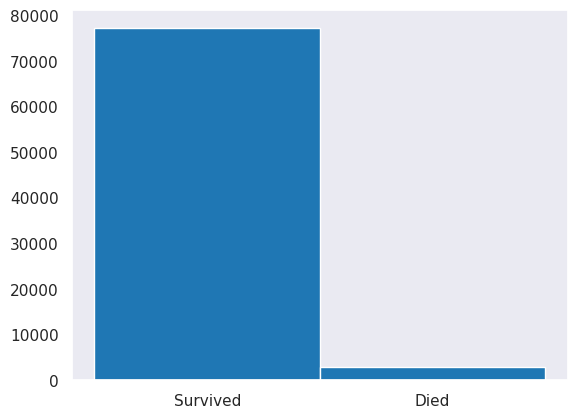

In [10]:
ys.hist(bins=2, grid=False, align="left")
plt.xticks([0, 0.5], ["Survived", "Died"])
# plt.savefig("img/tobe.png", dpi=300)
plt.show()

### Code : Produire les graphiques suivants

* Diagrammes à barres de certaines variables catégorielles (par exemple "LANGUAGE", "MARITAL_STATUS")

* Montrez la corrélation entre certaines variables et la variable cible y

* Un autre graphique ou toute analyse exploratoire à laquelle vous pouvez penser

Exemple

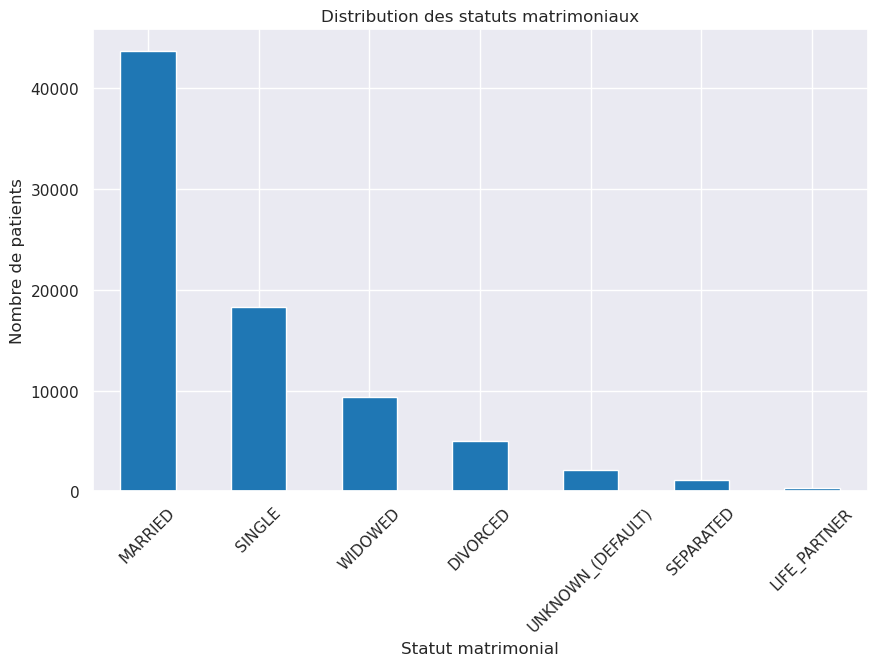

In [11]:
marital_status_counts = x_df["MARITAL_STATUS"].value_counts()
plt.figure(figsize=(10, 6))
marital_status_counts.plot(kind='bar')
plt.title('Distribution des statuts matrimoniaux')
plt.xlabel('Statut matrimonial')
plt.ylabel('Nombre de patients')
plt.xticks(rotation=45)
plt.show()

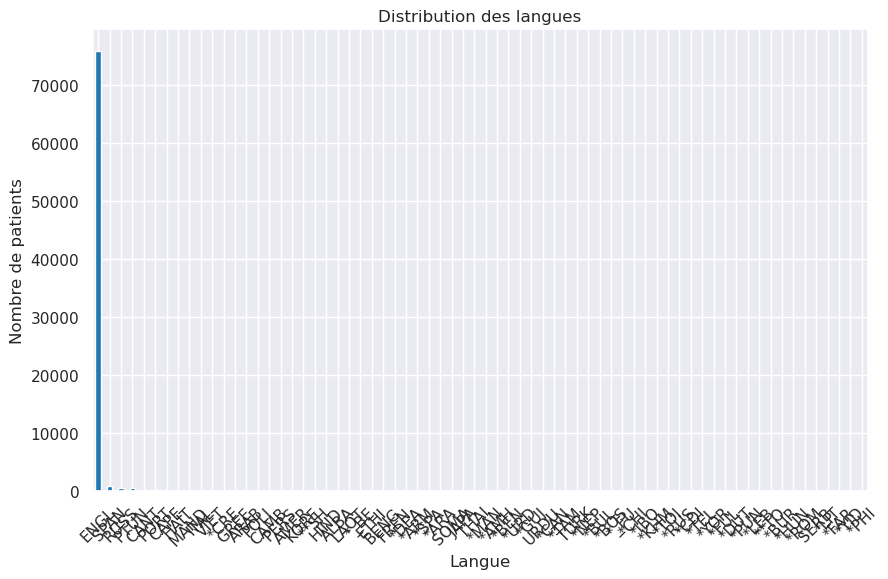

In [12]:
language_counts = x_df["LANGUAGE"].value_counts()
plt.figure(figsize=(10, 6))
language_counts.plot(kind='bar')
plt.title('Distribution des langues')
plt.xlabel('Langue')
plt.ylabel('Nombre de patients')
plt.xticks(rotation=45)
plt.show()

Beaucoup d'informations qui ne sont pas essentielles.

#### Corrélations

In [13]:
##Premier Jet 
filt = x_df.select_dtypes(exclude = ['object'])
corr_f= filt.corrwith(ys)
corr_bool = abs(corr_f) >= 0.03
data_f = pd.Series()
for col in corr_bool.index:
    if (corr_bool[col] == True):
        data_f[col] = corr_f[col]
corr_temp=pd.DataFrame(data_f).style.background_gradient(cmap='coolwarm')


In [14]:
# les x meilleurs 
x= 15
corr_temp2=pd.DataFrame(corr_f.head(x)).style.background_gradient(cmap='coolwarm')


In [15]:
x = 15
top_corr = corr_f.abs().nlargest(x)
corr_temp2 = pd.DataFrame(top_corr).style.background_gradient(cmap='coolwarm')
corr_temp2

,0
RESP_RATE_MEAN_DAY1,0.095771
Adltrespfl,0.090832
RESP_RATE_MAX_DAY1,0.090649
RESP_RATE_MEAN_DAY2,0.089380
RESP_RATE_MAX_DAY2,0.086141
HR_MAX_DAY2,0.073488
HR_MAX_DAY1,0.072596
HR_MEAN_DAY2,0.066076
TEMP_MAX_DAY2,0.065090
HR_MIN_DAY1,0.064780


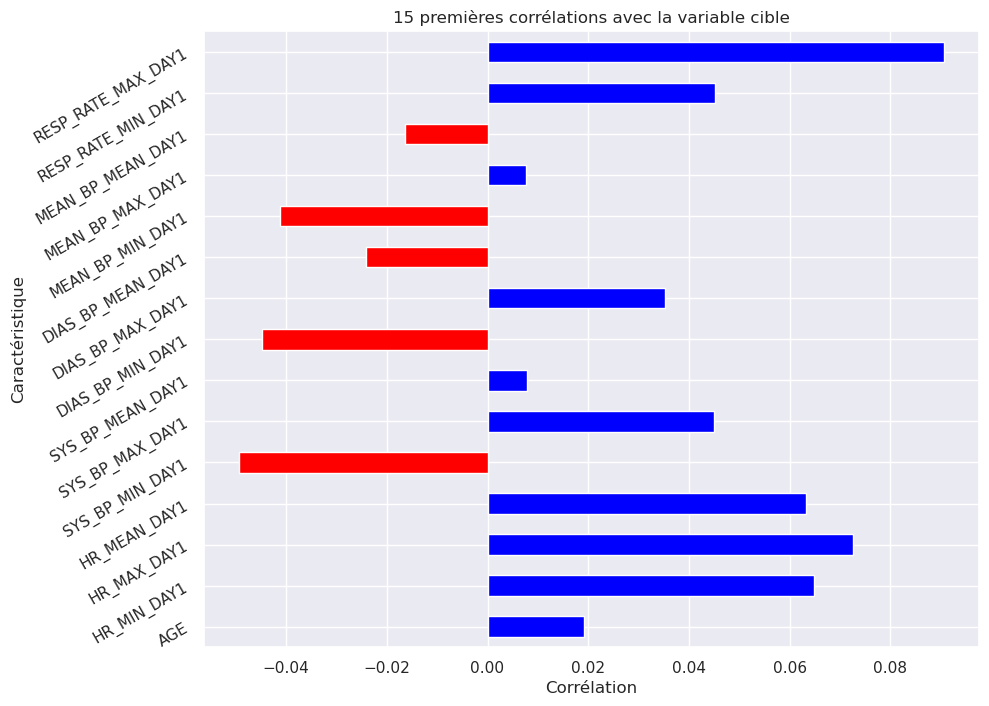

In [16]:
plt.figure(figsize=(10, 8))
corr_top15 = corr_f.head(15)
corr_top15.plot(kind='barh', color=(corr_top15 > 0).map({True: 'blue', False: 'red'}), rot=30)
plt.title('15 premières corrélations avec la variable cible')
plt.xlabel('Corrélation')
plt.ylabel('Caractéristique')
plt.show()

Astuce :

* Utilisez un graphique avec des barres horizontales `barh` (pour visualiser les valeurs positives et négatives)

On remarque que "RESP_RATE_MAX_DAY1" est l'attribut le plus corrélé a la survie du patient.

#### Autres graphiques ou résultats d'une analyse exploratoire

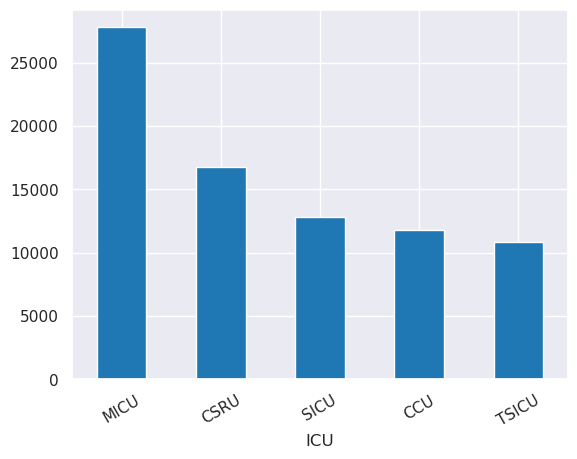

In [17]:
x_service_cnts = x_df["ICU"].value_counts()
x_service_cnts.plot.bar(rot=30)
plt.show()

Mémo pour les différentes class dans ICU  (Intensive Care Unit) :
* MICU = mobile 
* CSRU = Cardiac and Stroke
* SICU = Surgical Intensive
* CCU = Coronary 
* TSICU = Trauma Surgical 

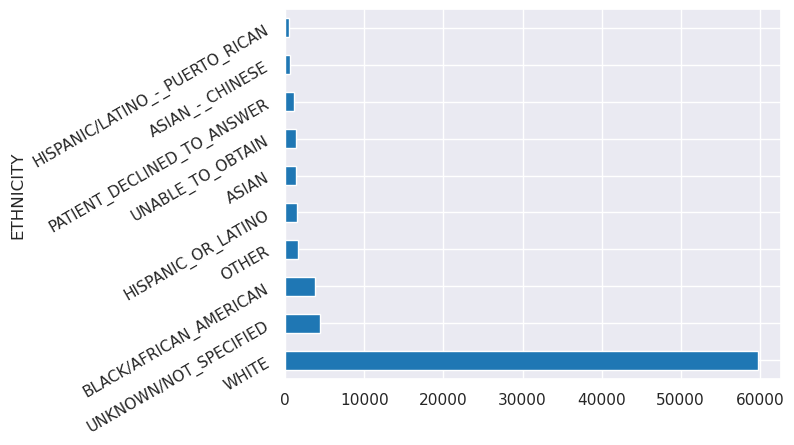

In [18]:
x_marital_cnts = x_df["ETHNICITY"].value_counts().head(10)
x_marital_cnts.plot.barh(rot=30)
plt.show()

## 4. Pre-traitement

### Code : Traitement du problème des valeurs manquantes (ou non définies, NAN)

La solution la plus simple est d'éliminer l'ensemble des colonnes où il y a des données manquantes, mais on perd de l'information.

Vu le faible nombre d'instances concernées (maximum 6 : voir ci-dessous) il parait plus pertinent de supprimer les lignes (instances) plutôt que les colonnes entières (variables).

La solution que nous choisissons ici est une troisième, celle de remplacer les valeurs non définies par la valeur la plus probable de la variable. Comme ces valeurs manquantes concernent exclusivement des variables catégorielles et binaires, la valeur la plus probable est le *mode* (voir cours : `part-5-slides.pdf`).

In [19]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


In [20]:
x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]
x_miss

LANGUAGE                              1
MARITAL_STATUS                        1
ICU                                   2
ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
Othnervdx                             1
dtype: int64

In [21]:
x_test_nans = x_test_df.isna().sum()
x_test_miss = x_test_nans[x_test_nans > 0]
x_test_miss

LANGUAGE                              2
ECodes:Adverseeffectsofmedicalcare    3
dtype: int64

In [22]:
x_miss_rows = x_df.isna().any(axis="columns")

x_df.loc[x_miss_rows, x_miss.index]

,LANGUAGE,MARITAL_STATUS,ICU,ECodes:Adverseeffectsofmedicalcare,Otnutritdx,Othnervdx
2251,ENGL,MARRIED,MICU,NaN,0,0
9983,ENGL,MARRIED,MICU,0,NaN,0
10549,ENGL,MARRIED,MICU,0,NaN,0
10831,ENGL,MARRIED,MICU,NaN,1,0
17012,ENGL,MARRIED,CSRU,NaN,0,1
23088,ENGL,MARRIED,NaN,0,0,0
32539,ENGL,NaN,CSRU,0,0,0
42762,ENGL,SINGLE,TSICU,NaN,0,0
53191,NaN,MARRIED,MICU,0,0,0
53390,CAPE,MARRIED,NaN,0,0,0


#### Remplacement des NAN

In [23]:
na_cols = set(x_miss.index) | set(x_test_miss.index)

for col in na_cols:
    x_df[col].fillna(x_df[col].mode()[0], inplace=True)
    x_test_df[col].fillna(x_test_df[col].mode()[0], inplace=True)

In [24]:
print(
    x_df.isna().any().any(),
    x_test_df.isna().any().any(),
    sep="\n",
)

False
False


In [25]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


### Gestion des catégories rares

Simplifiez les données en regroupant par exemple les catégories rares.

In [26]:
print(x_test_df["RELIGION"].value_counts())

RELIGION
CATHOLIC                  7517
NOT_SPECIFIED             3764
UNOBTAINABLE              2208
PROTESTANT_QUAKER         2208
JEWISH                    1855
OTHER                     1171
EPISCOPALIAN               338
CHRISTIAN_SCIENTIST        221
GREEK_ORTHODOX             216
BUDDHIST                   140
MUSLIM                      87
UNITARIAN-UNIVERSALIST      62
JEHOVAH'S_WITNESS           60
HINDU                       59
ROMANIAN_EAST._ORTH         42
7TH_DAY_ADVENTIST           32
BAPTIST                     16
HEBREW                       4
LUTHERAN                     1
Name: count, dtype: int64


In [27]:
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        print(keeps)

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"


merge_rare_categories([x_df, x_test_df], col="RELIGION", keep_n=5)
print(x_test_df["RELIGION"].value_counts())

Index(['CATHOLIC', 'NOT_SPECIFIED', 'UNOBTAINABLE', 'PROTESTANT_QUAKER',
       'JEWISH'],
      dtype='object', name='RELIGION')
RELIGION
CATHOLIC             7517
NOT_SPECIFIED        3764
OTHER                2449
UNOBTAINABLE         2208
PROTESTANT_QUAKER    2208
JEWISH               1855
Name: count, dtype: int64


In [28]:

merge_rare_categories([x_df, x_test_df], col="LANGUAGE", keep_n=5)
merge_rare_categories([x_df, x_test_df], col="ETHNICITY", keep_n=10)
print(x_test_df["LANGUAGE"].value_counts())
print(x_test_df["ETHNICITY"].value_counts())

Index(['ENGL', 'SPAN', 'RUSS', 'PTUN', 'CANT'], dtype='object', name='LANGUAGE')
Index(['WHITE', 'UNKNOWN/NOT_SPECIFIED', 'BLACK/AFRICAN_AMERICAN', 'OTHER',
       'HISPANIC_OR_LATINO', 'ASIAN', 'UNABLE_TO_OBTAIN',
       'PATIENT_DECLINED_TO_ANSWER', 'ASIAN_-_CHINESE',
       'HISPANIC/LATINO_-_PUERTO_RICAN'],
      dtype='object', name='ETHNICITY')
LANGUAGE
ENGL     18883
OTHER      485
SPAN       258
RUSS       151
PTUN       147
CANT        77
Name: count, dtype: int64
ETHNICITY
WHITE                             14930
OTHER                              1423
UNKNOWN/NOT_SPECIFIED              1088
BLACK/AFRICAN_AMERICAN              930
UNABLE_TO_OBTAIN                    380
HISPANIC_OR_LATINO                  377
ASIAN                               354
PATIENT_DECLINED_TO_ANSWER          264
ASIAN_-_CHINESE                     144
HISPANIC/LATINO_-_PUERTO_RICAN      111
Name: count, dtype: int64



Les différents attributs où une fusion de valeur pourrait etre faite (de types categorielles ) sont : ADMITTIME, DISCHTIME, INSURANCE, RELIGION, MARITAL_STATUS, ETHNICITY, ICU.
Deux raisons pour ne pas appliquer la fonction à certains attributs ressort :
* Premièrement, il n'y aurait pas de sens  a fusionner des categories dazns ADMITTIME/DISCHTIME

* Deuxièmement MARITAL_STATUS, INSURANCE et  ICU n'ont pas beaucoup de valeurs possibles

Il nous reste donc ETHNICITY, LANGUAGE et RELIGION ou des fusions de valeur sont possibles.

### Transformation des données catégorielles en nombres entiers en utilisant deux types d'encodage

Les variables catégorielles sont présentées sous forme de chaines de caractères. La plupart des modèles ne pourront pas les prendre en entrée.

#### Encodage numérique simple

Deux des méthodes les plus simples sont `LabelEncoder` de Scikit-Learn et `factorize` de pandas. Elles consistent simplement à remplacer chaque nouvelle catégorie rencontrée par un entier, en commençant par 0. Ce n'est cependant peut-être pas la méthode la plus efficace, car elle présuppose une proximité entre les catégories codées avec des valeurs proches.

In [29]:
def label_encode(df, other_df, only_binary=False):
    """
    Select categorical variables and encode them in integers.
    """
    char_cols = df.dtypes.pipe(lambda x: x[x == "object"]).index
    # print(char_cols)

    for col in char_cols:
        n_categories = len(x_df[col].unique())

        if not only_binary or n_categories == 2:
            codes, uniques = pd.factorize(df[col])
            df[col] = codes

            # Create conversion dic to convert values of test set as well
            cat2code = {k: v for v, k in enumerate(uniques)}
            other_df[col] = other_df[col].map(cat2code)

In [30]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


In [31]:
print(x_df.shape, ys.shape)

(79999, 337) (79999,)


In [32]:
x_fact_df = x_df.copy()
x_test_fact_df = x_test_df.copy()

label_encode(x_fact_df, x_test_fact_df)

In [33]:
x_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,0,0,0,0,0,0,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,2,1,1,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


In [34]:
x_test_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,3,0,5,3,0,0,18,72.6,113,96.5,...,0,0,0,0,0,0,0,0,0,0
1,2,0,2,1,3,0,56,66.6,107,83.8,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,1,0,1,32,69.7,103,87.3,...,0,0,0,0,0,0,0,0,0,0


#### Encodage 1-Hot

Un autre type d'encodage est souvent plus efficace, il a notamment l'avantage de ne pas ordonner les classes d'une manière particulière (pas forcément en adéquation avec la proximité de ces classes entre elles).

Une méthode de pandas permet de le réaliser en 1 ligne de code avec la fonction `get_dummies`.

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

In [35]:
# Encode binary features on a single column (no need for 1-hot)
label_encode(x_df, x_test_df, only_binary=True)

x_all_1h_df = pd.get_dummies(pd.concat([x_df, x_test_df]))

x_1h_df = x_all_1h_df.iloc[: len(x_df)].copy()
x_test_1h_df = x_all_1h_df.iloc[len(x_df):].copy()

print(x_df.shape, x_test_df.shape)
print(x_1h_df.shape, x_test_1h_df.shape)

(79999, 337) (20001, 337)
(79999, 370) (20001, 370)


#### Suppression des variables à valeur unique (constantes)

In [36]:
const_cols = {col for col in x_1h_df if len(x_1h_df[col].unique()) == 1}
len(const_cols)

173

In [37]:
x_1h_df.drop(const_cols, axis="columns", inplace=True)
x_test_1h_df.drop(const_cols, axis="columns", inplace=True)

print(x_1h_df.shape, x_test_1h_df.shape)

(79999, 197) (20001, 197)


### Création de l'ensemble de validation

In [38]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    x_1h_df, ys, test_size=0.3
)
x_train.shape
# VARS: x_df, x_fact_df, x_1h_df

(55999, 197)

In [39]:
x_1h_df

,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,SYS_BP_MIN_DAY1,SYS_BP_MAX_DAY1,SYS_BP_MEAN_DAY1,DIAS_BP_MIN_DAY1,DIAS_BP_MAX_DAY1,...,ETHNICITY_OTHER,ETHNICITY_PATIENT_DECLINED_TO_ANSWER,ETHNICITY_UNABLE_TO_OBTAIN,ETHNICITY_UNKNOWN/NOT_SPECIFIED,ETHNICITY_WHITE,ICU_CCU,ICU_CSRU,ICU_MICU,ICU_SICU,ICU_TSICU
0,0,21,57.2,109,70.8,79.8,120,94.4,26.9,68.9,...,False,False,False,False,True,False,False,False,True,False
1,1,39,79.3,121,96.9,94,139,114,38.6,74.3,...,False,False,False,False,True,True,False,False,False,False
2,1,40,118,175,141,123,144,135,67.8,83.3,...,True,False,False,False,False,False,False,True,False,False
3,1,75,83.8,89.2,86.1,111,145,128,61.1,75.2,...,False,False,False,False,True,True,False,False,False,False
4,0,55,60.9,106,80.6,87.6,128,99.1,42.7,64,...,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79994,0,76,56,97.9,79.7,77.5,120,102,26.7,49.7,...,False,False,False,False,True,False,True,False,False,False
79995,0,38,55.1,86,67.6,83.1,175,119,40.4,79.4,...,False,False,False,False,True,False,False,False,False,True
79996,0,90,74.3,91.3,91.4,95.9,139,131,52.7,85.1,...,False,False,False,False,True,False,False,False,True,False
79997,1,57,79.3,129,98.7,108,142,132,57.1,77.4,...,False,False,False,False,False,False,False,False,False,True


### Réduction de la dimension via l'ACP (PCA)

Testez l'ACP pour réduire le nombre de dimensions et observez si cela améliore le résultat.

Avant d'appliquer la ACP, il est conseillé de centrer-réduire les données (e.g., via `preprocessing.StandardScaler()`).

In [40]:
from sklearn.preprocessing import StandardScaler

# On standardize les données
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test_1h_df)

# Appliquer l'ACP pour réduire le nombre de dimensions
n_components = 10
pca = decomposition.PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)



print(x_train_pca.shape, x_test_pca.shape)


(55999, 10) (20001, 10)


Proposez un graphique qui représente les 2 premières dimensions de la PCA et commentez succinctement.

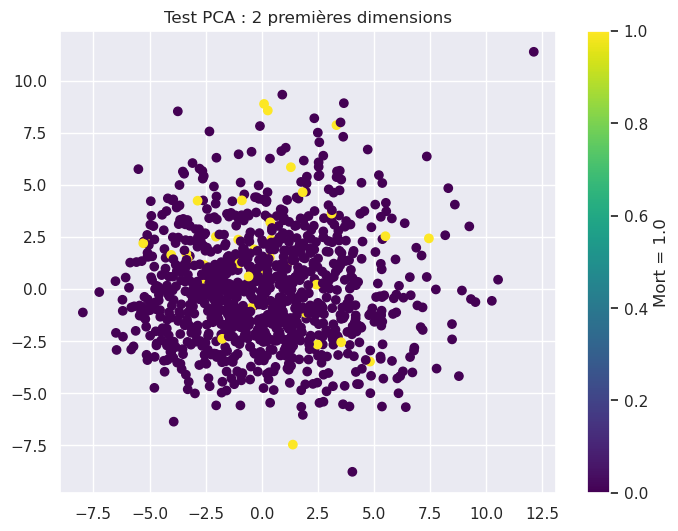

In [41]:
plt.figure(figsize=(8, 6))
plt.scatter(x_train_pca[:1000, 0], x_train_pca[:1000, 1], c=y_train[:1000], cmap='viridis')
plt.title('Test PCA : 2 premières dimensions')
plt.colorbar(label='Mort = 1.0')
plt.grid(True)
plt.show()

D'après le graphique, on peut constater que la réduction avec le PCA ne nous donne pas des informations très pertinentes sur les deux premières dimensions. En effet on peut voir que les points jaunes qui représentent les morts chevauchent beaucoup les points violets qui représentent les vivants, et les points jaunes ne se concentrent pas en 1 point particulier. Il faudrait donc regarder le résultat sous 10 dimensions, ce qui n'est pas possible.
Il faudrait utiliser les résultats du PCA avec des classificateurs pour avoir des résultats plus pertinents. On peut aussi noter que Mort et Vivant ne sont pas linéairement séparable.

# 5. Modèles de classification : SVC (expérimental), RFC, HGB

Entrainez le modèle

### Baseline

`LogisticRegression` or `RandomForestClassifier`

In [42]:
SCORINGS = "balanced_accuracy"

## Version standard

 *Temps et resultats obtenues sur les fittings précedent :*
 
<code>
Start fitting at    14:16:41 ...
SVC fitting and predicting done at   14:36:07      Balanced accuracy score, SVC: 0.716
RFC fitting and predicting done at   14:36:23      Balanced accuracy score, RFC: 0.5
HGB fitting and predicting done at   14:45:22      Balanced accuracy score, HGB: 0.726 </code>



*Au vu du temps demandé pour fit le SVC, celui-ci sera ecarté*

 

In [43]:


#SVC 
#model_SVC= svm.SVC(class_weight='balanced', degree = 1)
#now = datetime.datetime.now()
#print('Start fitting at  ',now.strftime(" %H:%M:%S ..."))
#model_SVC.fit(x_train,y_train)
#y_pred_SVC = model_SVC.predict(x_valid)
#now = datetime.datetime.now()
#print('SVC fitting and predicting done at ',now.strftime(" %H:%M:%S"))


#RFC
nb_e=50
model_RFC= ensemble.RandomForestClassifier(n_estimators=nb_e,class_weight='balanced')
model_RFC.fit(x_train,y_train)
y_pred_RFC = model_RFC.predict(x_valid)
now = datetime.now()
print('RFC fitting and predicting done at ',now.strftime(" %H:%M:%S"))



#HistGradientBoosting
model_HGB=ensemble.HistGradientBoostingClassifier(max_iter=100, scoring = SCORINGS,class_weight='balanced')
model_HGB.fit(x_train,y_train)
y_pred_HGB = model_HGB.predict(x_valid)
now = datetime.now()
print('HGB fitting and predicting done at ',now.strftime(" %H:%M:%S"))


RFC fitting and predicting done at   13:45:37
HGB fitting and predicting done at   13:50:02


## Version PCA

 *Temps et resultats obtenues sur les fittings précedent :*
 
 <code>
Start fitting at    14:46:34 ...
SVC_PCA fitting and predicting done at   14:49:49      Balanced accuracy score, SVC with PCA: 0.508
RFC_PCA fitting and predicting done at   14:49:59      Balanced accuracy score, RFC with PCA: 0.5
HGB_PCA fitting and predicting done at   14:54:59      Balanced accuracy score, HGB with PCA: 0.5 </code>

 

In [44]:
#Version PCA

#SVC 
model_SVC_PCA= svm.SVC(class_weight='balanced', degree = 1)

now = datetime.now()
print('Start fitting at  ',now.strftime(" %H:%M:%S ..."))

model_SVC_PCA.fit(x_train_pca,y_train)
y_pred_SVC_PCA = model_SVC_PCA.predict(x_test_pca)
now = datetime.now()
print('SVC_PCA fitting and predicting done at ',now.strftime(" %H:%M:%S"))

#RFC
model_RFC_PCA= ensemble.RandomForestClassifier(n_estimators=nb_e,class_weight='balanced')
model_RFC_PCA.fit(x_train_pca,y_train)
y_pred_RFC_PCA = model_RFC_PCA.predict(x_test_pca)
now = datetime.now()
print('RFC_PCA fitting and predicting done at ',now.strftime(" %H:%M:%S"))

#HistGradientBoosting
model_HGB_PCA=ensemble.HistGradientBoostingClassifier(max_iter=100,scoring = SCORINGS,class_weight='balanced')
model_HGB_PCA.fit(x_train_pca,y_train)
y_pred_HGB_PCA = model_HGB_PCA.predict(x_test_pca)
now = datetime.now()
print('HGB_PCA fitting and predicting done at ',now.strftime(" %H:%M:%S"))

Start fitting at    13:51:27 ...
SVC_PCA fitting and predicting done at   13:54:45
RFC_PCA fitting and predicting done at   13:54:55
HGB_PCA fitting and predicting done at   13:56:37


# 6. Évaluations

In [45]:
#scoreSVC = metrics.balanced_accuracy_score(y_valid[:y_valid.size], y_pred_SVC) 
scoreRFC = metrics.balanced_accuracy_score(y_valid[:y_valid.size], y_pred_RFC)  
scoreHGB = metrics.balanced_accuracy_score(y_valid[:y_valid.size], y_pred_HGB)  

scoreSVC_PCA = metrics.balanced_accuracy_score(y_valid[:20001], y_pred_SVC_PCA)  
scoreRFC_PCA = metrics.balanced_accuracy_score(y_valid[:20001], y_pred_RFC_PCA)  
scoreHGB_PCA = metrics.balanced_accuracy_score(y_valid[:20001], y_pred_RFC_PCA) 

#print(f"Balanced accuracy score, SVC: {scoreSVC:.3g}")
print(f"Balanced accuracy score, RFC: {scoreRFC:.3g}")
print(f"Balanced accuracy score, HGB: {scoreHGB:.3g}")

print(f"Balanced accuracy score, SVC with PCA: {scoreSVC_PCA:.3g}")
print(f"Balanced accuracy score, RFC with PCA: {scoreRFC_PCA:.3g}")
print(f"Balanced accuracy score, HGB with PCA: {scoreHGB_PCA:.3g}")



Balanced accuracy score, RFC: 0.5
Balanced accuracy score, HGB: 0.718
Balanced accuracy score, SVC with PCA: 0.493
Balanced accuracy score, RFC with PCA: 0.5
Balanced accuracy score, HGB with PCA: 0.5


Les scores de précision équilibrée obtenus pour les modèles RFC et GNB, avec ou sans l'utilisation de PCA , sont tous proches de 0.5. Cad que ces modèles ne sont pas capables de distinguer efficacement entre les classes positives et négatives de la variable cible, suggérant ainsi une faible capacité de prédiction sur l'ensemble de la validation.

Les scores obtenus pour le modèle rfc, avec ou sans PCA, est proche de 0.5, i.e que le modèle n'est pas capable de distinguer efficacement les classes de la variable cible, suggérant ainsi une faible capacité de prédiction sur l'ensemble de validation.
En revanche, on remarque  un score légèrement au desus pour le SVC avec PCA (0.508) et un score bien plus honorable  pour le HGB (726) .

# Code : Validation croisée

Le code ci-dessus utilise une méthode simple (*hold out*) pour mesurer le score de validation. Utilisez la validation croisée (pour obtenir une estimation plus fiable) combinée à l'exploration des hyperparamètres (pour améliorer les résultats).

Vous pouvez changer la valeur du nombre de validation croisée (CV) selon la valeur de l'erreur et le temps d'entrainement des modèles (compromis).

In [46]:
CV = 5

 *Temps et resultats obtenues sur les gridCV fitted précedent :*
 
 
 

## Initialisation des grid

In [47]:
import datetime


#INIT Hyper parameters
paramRFC = {'n_estimators' : [10,20,50,100,150]}
paramHGB = {}
paramSVC = {'degree' : [1, 3]}

#Init random Select for cross validation
#grid_SVC = model_selection.GridSearchCV(svm.SVC(class_weight='balanced'), paramSVC,cv=CV) //On ne prend pas ća en compte pour des questions d'optimisation.
grid_RFC = model_selection.GridSearchCV(ensemble.RandomForestClassifier(class_weight='balanced'),paramRFC,cv=CV,scoring=SCORINGS)
grid_HGB = model_selection.GridSearchCV(ensemble.HistGradientBoostingClassifier(max_iter= 100,class_weight ='balanced'),paramHGB,cv=CV,scoring=SCORINGS)

grid_SVC_PCA = model_selection.GridSearchCV(svm.SVC(class_weight='balanced'),paramSVC,cv=CV)
grid_RFC_PCA = model_selection.GridSearchCV(ensemble.RandomForestClassifier(),paramRFC,cv=CV,scoring=SCORINGS)
grid_HGB_PCA = model_selection.GridSearchCV(ensemble.HistGradientBoostingClassifier(),paramHGB,cv=CV,scoring=SCORINGS)

## Fit : Version standard

In [48]:
#Fit
# Repère timer
now = datetime.datetime.now()
print('Start fitting at  ',now.strftime(" %H:%M:%S ..."))

#grid_SVC.fit(x_train,y_train)
#now = datetime.datetime.now()
#print('grid_SVC.fit done at ',now.strftime(" %H:%M:%S"))

grid_RFC.fit(x_train,y_train)
now = datetime.datetime.now()
print('grid_RFC.fit done at ',now.strftime(" %H:%M:%S"))
                                             
grid_HGB.fit(x_train,y_train)
now = datetime.datetime.now()
print('grid_HGB.fit done at ',now.strftime(" %H:%M:%S"))

Start fitting at    13:56:51 ...
grid_RFC.fit done at   14:03:40
grid_HGB.fit done at   14:58:34


## Fit : Version PCA

In [49]:
grid_SVC_PCA.fit(x_train_pca,y_train)
now = datetime.datetime.now()
print('grid_SVC_PCA.fit done at ',now.strftime(" %H:%M:%S"))

grid_RFC_PCA.fit(x_train_pca,y_train)
now = datetime.datetime.now()
print('grid_RFC_PCA.fit done at ',now.strftime(" %H:%M:%S"))

grid_HGB_PCA.fit(x_train_pca,y_train)
now = datetime.datetime.now()
print('grid_HGB_PCA.fit done at ',now.strftime(" %H:%M:%S"))                                            

grid_SVC_PCA.fit done at   15:25:17
grid_RFC_PCA.fit done at   15:31:05
grid_HGB_PCA.fit done at   16:07:34


## Résultat des grid

In [50]:
print('fit done')
print("RFC Meilleurs params:", grid_RFC.best_params_,"RFC-Meilleur score:", grid_RFC.best_score_)
print("HGB Meilleurs params:", grid_HGB.best_params_,"HGB-Meilleur score:", grid_HGB.best_score_)
print("\n")

print("SVC_PCA Meilleurs params:", grid_SVC_PCA.best_params_,"SVC-Meilleur score:", grid_SVC_PCA.best_score_)
print("RFC_PCA Meilleurs params:", grid_RFC_PCA.best_params_,"RFC_PCA Meilleur score:", grid_RFC_PCA.best_score_)
print("HGB_PCA Meilleurs params:", grid_HGB.best_params_,"HGB-Meilleur score:", grid_HGB.best_score_)

fit done
RFC Meilleurs params: {'n_estimators': 10} RFC-Meilleur score: 0.5004890506285127
HGB Meilleurs params: {} HGB-Meilleur score: 0.7162381559419859


SVC_PCA Meilleurs params: {'degree': 1} SVC-Meilleur score: 0.7291201366831223
RFC_PCA Meilleurs params: {'n_estimators': 20} RFC_PCA Meilleur score: 0.5002029040371452
HGB_PCA Meilleurs params: {} HGB-Meilleur score: 0.7162381559419859


* **Pour 2 des modèles** (au moins 1 autre que les 2 proposés en baselines) :

    * Pour différentes valeurs d'un des hyperparamètres, donnez les `balanced_accuracy` moyennes de la validation croisée sous forme de Boxplots (ou de diagramme à bâtons avec une barre d'erreur) : voir l'exemple présenté dans le graphique ci-dessous.
    
    * Explicitez succinctement quelles observations en tirer concernant la stabilité des prédictions.

![](img/boxplot-cv.png)

## Box-plots de 2 grids de classificateur

## Box-plots grid : SVC-PCA

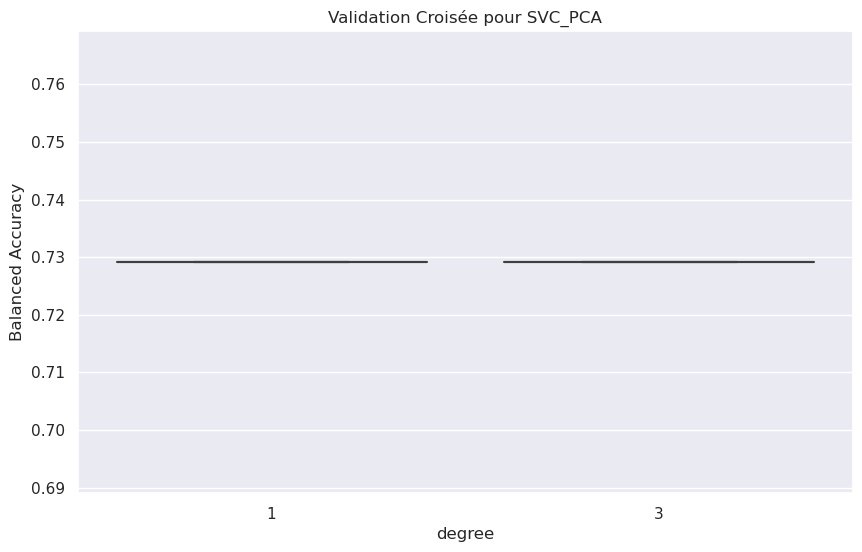

In [51]:
#SVC-PCA

import seaborn as sns
import matplotlib.pyplot as plt

param_values = [1, 3]
scores = grid_SVC_PCA.cv_results_['mean_test_score']

plt.figure(figsize=(10, 6))
sns.boxplot(x=param_values, y=scores)
plt.xlabel("degree")
plt.ylabel("Balanced Accuracy")
plt.title("Validation Croisée pour SVC_PCA")
plt.show()


## Box-plots grid : RFC

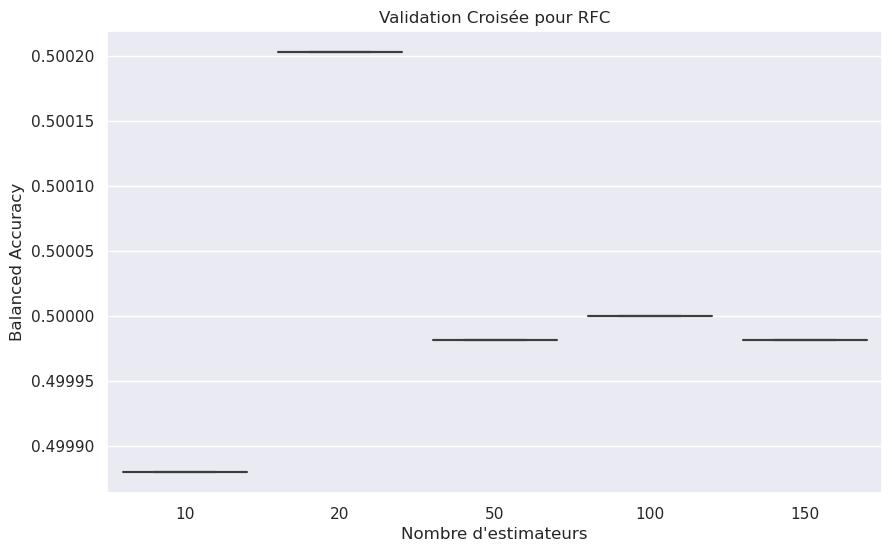

In [52]:
#RFC

import seaborn as sns
import matplotlib.pyplot as plt

param_values = [10,20,50,100,150];
scores = grid_RFC_PCA.cv_results_['mean_test_score']

plt.figure(figsize=(10, 6))
sns.boxplot(x=param_values, y=scores)
plt.xlabel("Nombre d'estimateurs")
plt.ylabel("Balanced Accuracy")
plt.title("Validation Croisée pour RFC")
plt.show()


* **Pour chacun de ces 2 modèles, à partir des données de validation créées précédemment** (`x_valid`, `y_valid`) :

    * Mesurez l'aire sous la courbe ROC (AUC) à l'aide de la fonction de Scikit-Learn (`roc_auc_score`) et comparez les modèles avec leur combinaison respective d'hyperparamètres offrant le meilleur résultat.

## Redéclaration  des x-valid normalisé, avec application de la PCA pour régler une problèmatique de format

In [53]:
x_valid_scaled = scaler.transform(x_valid)
x_valid_pca = pca.transform(x_valid_scaled)

## Roc SVC-PCA

In [54]:
y_pred_SVC_CPA_best = grid_SVC_PCA.best_estimator_.predict(x_valid_pca)
print("auc_score pour SVC-PCA : ",metrics.roc_auc_score(y_valid,y_pred_SVC_CPA_best))

auc_score pour SVC-PCA :  0.6626032642559949


## Roc RFC-PCA

In [55]:
y_pred_RFC_best = grid_RFC.best_estimator_.predict(x_valid)
y_pred_RFC_PCA_best = grid_RFC_PCA.best_estimator_.predict(x_valid_pca)
print("auc_score pour RFC : ",metrics.roc_auc_score(y_valid,y_pred_RFC_best))
print("auc_score pour RFC_PCA : ",metrics.roc_auc_score(y_valid,y_pred_RFC_PCA_best))
    

auc_score pour RFC :  0.5017225784406344
auc_score pour RFC_PCA :  0.49995678478824546


## ROC HGB

In [56]:

y_pred_HGB_best = grid_HGB.best_estimator_.predict(x_valid)
print("auc_score pour HGB : ",metrics.roc_auc_score(y_valid,y_pred_HGB_best))
    

auc_score pour RFC :  0.7246718658921429


## Matrice de confusion : SVC-PCA

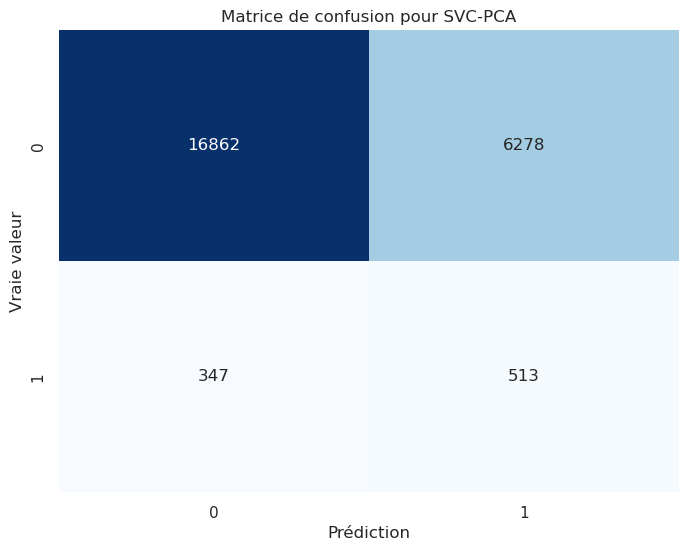

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# la transformation PCA sur les données de validation
x_valid_scaled = scaler.transform(x_valid)
x_valid_pca = pca.transform(x_valid_scaled)

y_pred_SVC_best = grid_SVC_PCA.best_estimator_.predict(x_valid_pca) # la prédiction avec le meilleur modèle LSVC

cm_SVC = confusion_matrix(y_valid, y_pred_SVC_best)

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm_SVC, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prédiction')
plt.ylabel('Vraie valeur')
plt.title('Matrice de confusion pour SVC-PCA')
plt.show()


Dans la matrice de confusion pour le modèle SVC_PCA, on a : 15738 prédictions correctes de la classe 0 cad des individus vivant en tant que classe 0,  534 prédictions correctes de la classe 1 cad des individus mort en tant que classe 1, 7417 erreurs de prédiction où la classe 0 cad des individus vivant a été incorrectement classée comme classe 1 (mort) et 311 erreurs de prédiction où la classe 1 cad des individus mort a été incorrectement classée comme classe 0 (vivant). Ces valeurs représentent les vraies négatives et positives, les fausses positives et négatives.

## Matrice de confusion : RFC_PCA

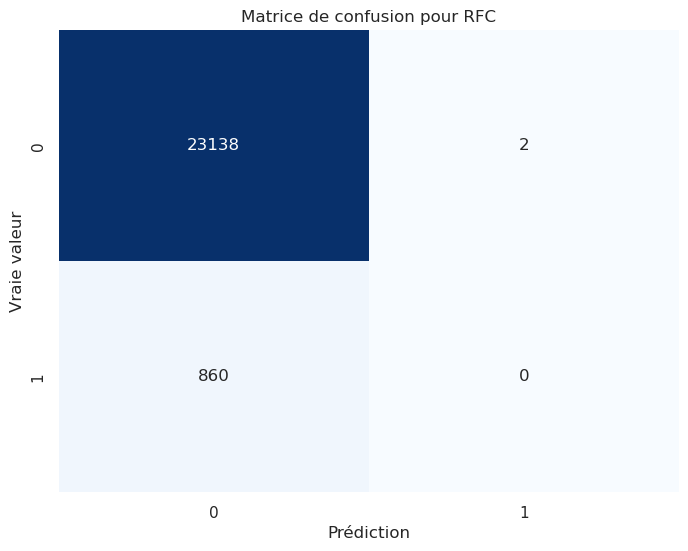

In [58]:
y_pred_RFC_best = grid_RFC_PCA.best_estimator_.predict(x_valid_pca) # la prédiction avec le meilleur modèle RFC

cm_RFC = confusion_matrix(y_valid, y_pred_RFC_best)

# Affichage de la matrice de confusion pour RFC
plt.figure(figsize=(8, 6))
sns.heatmap(cm_RFC, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prédiction')
plt.ylabel('Vraie valeur')
plt.title('Matrice de confusion pour RFC')
plt.show()


Dans la matrice de confusion pour le modèle RFC_PCA, on a: 23148 prédictions correctes de la classe 0 cad des individus vivant en tant que classe 0, 1 prédiction correcte de la classe 1 cad des individus mort en tant que classe 1, 7 erreurs de prédiction où la classe 0 cad des individus vivant a été incorrectement classée comme classe 1 (mort), 844 erreurs de prédiction où la classe 1 cad des individus mort a été incorrectement classée comme classe 0 (vivant). Ces valeurs représentent les vraies négatives,positives, les fausses positives et négatives.

* **Pour le modèle et sa combinaison d'hyperparamètres offrant le meilleur résultat** :

    * Réalisez la matrice de confusion et décrivez-la succinctement.

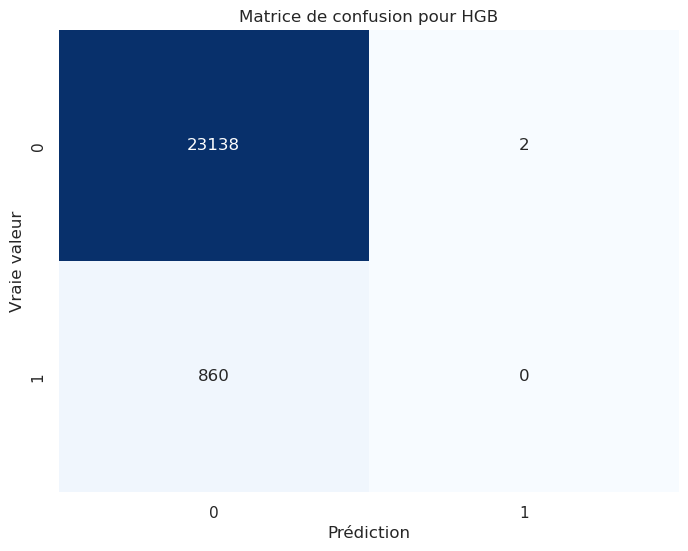

In [59]:
cm_HGB = confusion_matrix(y_valid, y_pred_HGB_best)

# Affichage de la matrice de confusion pour RFC
plt.figure(figsize=(8, 6))
sns.heatmap(cm_RFC, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prédiction')
plt.ylabel('Vraie valeur')
plt.title('Matrice de confusion pour HGB')
plt.show()

### Code : Essayez d'améliorer votre score

* Data augmentation (optionnel)

Vu le déséquilibre entre les classes à prédire (survive, died), on peut espérer améliorer le score en les rééquilibrant. Une approche typique est la génération de données (voir cours : `part-6-slides.pdf`). Une des méthodes de génération est [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE) (voir cours théorique), elle est notamment implémentée dans le module `imblearn`.

`imblearn` a été développé pour s'interfacer facilement avec `sklearn`.
Il propose notamment une version du `pipeline` qui permet l'intégration avec `sklearn`.

Ci-dessous voici un exemple de `pipeline` intégrant `imblearn` et `sklearn`.

## Amélioration RFC, HGB, SVC-PCA

In [60]:
model_RFC=grid_RFC.best_estimator_

pipe = imblearn.pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA()),
        ("resample", imblearn.over_sampling.SMOTE()),
        ("model", model_RFC),
    ]
)
pipe.fit(x_train,y_train)
y_hat = pipe.predict(x_valid)
print("RFC improved")
print(metrics.classification_report(y_valid, y_hat))

RFC improved
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     23140
           1       0.14      0.08      0.10       860

    accuracy                           0.95     24000
   macro avg       0.56      0.53      0.54     24000
weighted avg       0.94      0.95      0.94     24000



In [61]:
model_HGB=grid_HGB.best_estimator_
pipe = imblearn.pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA()),
        ("resample", imblearn.over_sampling.SMOTE()),
        ("model", model_HGB),
    ]
)
pipe.fit(x_train,y_train)
y_hat = pipe.predict(x_valid)
print("HGB improved")
print(metrics.classification_report(y_valid, y_hat))

HGB improved
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     23140
           1       0.17      0.33      0.22       860

    accuracy                           0.92     24000
   macro avg       0.57      0.63      0.59     24000
weighted avg       0.95      0.92      0.93     24000



In [62]:
model_SVC_PCA=grid_SVC_PCA.best_estimator_
pipe = imblearn.pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA()),
        ("resample", imblearn.over_sampling.SMOTE()),
        ("model", model_SVC_PCA),
    ]
)
pipe.fit(x_train,y_train)
y_hat = pipe.predict(x_valid)
print("SVC_PCA improved")
print(metrics.classification_report(y_valid, y_hat))

SVC_PCA improved
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     23140
           1       0.25      0.29      0.27       860

    accuracy                           0.94     24000
   macro avg       0.61      0.63      0.62     24000
weighted avg       0.95      0.94      0.95     24000



### Explication de ce que vous avez réalisé, conclusion et perspectives

* Commencez par donner votre meilleur résultat obtenu lors de vos soumissions

* Expliquez le chemin qui vous y a conduit

    * Ce que vous avez essayé :

        * Ce qui a fonctionné

        * Ce qui n'a pas fonctionné et comment vous l'avez solutionné

    * Quelle méthode avez-vous utilisée pour choisir les hyperparamètres ?

    * Comparer la durée d'entrainement des principaux modèles utilisés ?

* Qu'auriez-vous fait si vous aviez eu plus de temps ?

Nous avons essayé de nombreux classificateurs :
* Random Forest Classifier
* Support Vector Machine :
    * LSVC
    * SVC
* Gaussian Naive Bayes 
* Hist Gradient Boosting Classifier
* Linear Regression 

Le résultat du GNB n'était pas intéréssant et a donc été écarté.

LSVC et LR ne convergeant pas , ils ont aussi été écartés.

Il nous restait donc RFC, SVC et HGB.
Ces deux derniers nous ont posé des difficultés dû à leur temps de calcul. De nombreux tests d'hyperparamètres ont été effectués.

En ce qui concerne SVC, nous avons altérner à choisir entre 3 paramètres : le kernel, coeff0 et degree. Pour le kernel on a choisit entre rbf et poly, à poly est associé le paramètre coeff0. 
On a décidé finalement de prendre rbf car c'est le plus populaire et aussi car on voulait gagner en performance. Dès lors, on a aussi jeté coeff0 qui est un paramètre unique à poly. 
Quand a degree, on a choisit entre 1 et 3. Cependant, la valeur de degree ne semble pas avoir beaucoup d'impact. On a donc décidé de garder degree = 1 pour des questions d'optimisation.

Pour HGB qui est devenu le modèle le plus long a calculer, nous avons limité  ses options d'hyper paramètre (nombre d'iteration max) afin de ne pas perdre trop de temps sur le fitting.

Ensuite, pour choisir les hyperparamètres nous avons principalement essayé de tester plusieurs hyperparamètre et voir ce qui influence le plus les résultats grâce aux box-plots, et jeter ceux qui n'ont pas beaucoup d'influence sur le résultat. Cependant, on a décidé de garder "degree" pour SVC car on a pas réussi à trouver d'autre hyperparamètres plus intéressant.

Dans un ordre du plus rapide au plus lent  nous retrouvons : 
* RFC avec un temps moyen de 8 minutes
* SVC_PCA avec un temps moyen de 30 minutes
* HGB avec un temps moyen de 20 minutes / +1 heure (dû aux problèmes de serveur de Jupyter)


Nous avons ensuite pu comparer l'efficacité de nos différents modèles grace au ROC et aux matrices de confusions.
Nous avons tenter l'amélioration de ce 3 derniers.
Notre meilleur modèle s'est trouvé être SVC-PCA : c'est celui qui se trompe le moins avec le test sur les morts avec un score de 0.28, comparé à 0.23 du HGB, et du 0.07 de RFC

Si nous avions eu plus de temps : nous aurions exploré un peu plus les autres hyperparamètres non-testés des 3 modèles. Notamment les autres noyaux de SVC-PCA hormis rbf, linear et poly.

### Question (optionnelle)

* Qu'est-ce que le suréchantillonnage ?

* En quoi pourrait-il être utile dans ce problème ?

Le suréchantillonnage consiste à ajouter plus d'instance d'une classe minoritaire pour équilibrer le jeu de donnée. 

Ici, il pourrait être utile de rajouter plus d'instance de patient mort, pour pouvoir obtenir plus de donnée sur les morts et d'ainsi potentiellement obtenir de meilleurs résultats.

## 7. Enregistrer les prédictions

* Utilisez le code suivant pour faire des prédictions et pour les enregistrer sous forme de fichier ZIP
* Soumettez ce fichier ZIP sur [le site du challenge](https://competitions.codalab.org/competitions/30715#participate-submit_results)
("Participate > Submit/View Results > Submit")
* Faites de votre mieux pour être le ***premier sur le leaderboard !***



* Données : `x_test_fact_df`, `x_test_1h_df`

* Modèles : `model`, `search` (e.g., pour le `GridSearchCV`)

In [43]:
model_SVC_PCA= svm.SVC(class_weight='balanced', degree = 3)
model_SVC_PCA.fit(x_train_pca,y_train)
predictions = model_SVC_PCA.predict(x_test_pca)  # compute predictions
# VARS: x_test_df, x_test_fact_df, x_test_1h_df, x_test_1h_pcs
# Models: model, search

PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")

The submission is ready: Submissions/submission_2024-05-02T10-30-43.zip


---